#IMPORT

In [1]:
import pandas as pd
from tqdm import tqdm, trange
import numpy as np
import os
import gc
import time
import cv2
from matplotlib import pyplot as plt
from skimage.transform import resize
import seaborn as sns

from keras.applications.mobilenet import preprocess_input as preprocess_input_v1, decode_predictions as decode_predictions_v1
from keras.utils import load_img, img_to_array, to_categorical
from keras.applications import MobileNet
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam, AdamW, RMSprop, SGD
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import F1Score
from keras.callbacks import EarlyStopping, LearningRateScheduler
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)



Mounted at /content/drive


#Dataset

In [3]:
IMAGES_SRC = "/content/drive/MyDrive/GP_YOLOV5Model/avengers"

In [4]:
print(os.listdir(IMAGES_SRC))

['tony_stark (Robert Downey Jr.)', 'steve_rogers (Chris Evans)', 'Natasha_Romanoff (Scarlett Johansson)', 'bruce_banner (Mark Ruffalo)', 'clint_barton (Jeremy Renner)', 'thor (Chris Hemsworth)']


In [5]:
image = os.listdir(IMAGES_SRC)

#Preprocessing

In [6]:
face = []
for c in image:
    i = image.index(c)
    path = os.path.join(IMAGES_SRC, c)
    if os.path.exists(path):
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            im = cv2.imread(img_path)
            if im is not None:
                im = cv2.resize(im, (224, 224))  # Resize the image
                face.append([im, i])
            else:
                print(f"Failed to load image at {img_path}")
    else:
        print(f"Directory not found: {path}")

In [7]:
X=[]
Y=[]
for x,y in face:
    X.append(x)
    Y.append(y)

In [8]:
x=np.array(X)
y=np.array(Y)
print(x.shape,y.shape)

(916, 224, 224, 3) (916,)


In [9]:
encoder = OneHotEncoder(dtype=np.float32)

In [10]:
# Fit and transform the data
encoded_Y = encoder.fit_transform(y.reshape(-1, 1))
encoded_Y = encoded_Y.toarray()

In [11]:
encoded_Y.shape

(916, 6)

#train-test

In [12]:
X1_train, X1_test,Y1_train,Y1_test = train_test_split(x,encoded_Y, test_size=0.3, random_state=30)

#Modeling

#Training

In [13]:
from keras.applications import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the MobileNet model, pretrained on ImageNet
mobilenet_mdl = MobileNet(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)

# Using the output of the penultimate layer
base_input = mobilenet_mdl.input
base_output = mobilenet_mdl.layers[-2].output

# Adding the new top layers
top_model = GlobalAveragePooling2D(data_format="channels_last")(base_output)
top_model = Dense(1024, activation="relu")(top_model)
top_model = BatchNormalization()(top_model)  # Added batch normalization
top_model = Dropout(0.3)(top_model)  # Increased dropout rate
top_model = Dense(1000, activation="relu")(top_model)
top_model = BatchNormalization()(top_model)  # Added batch normalization
top_model = Dropout(0.3)(top_model)  # Increased dropout rate
top_model = Dense(6, activation="softmax")(top_model)

# Create the new model
model = Model(inputs=base_input, outputs=top_model)

# Compile the model with an optimizer and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='min', min_lr=0.0001)

# Fit the model
result = model.fit(
    X1_train, Y1_train,
    epochs=50,
    batch_size=32,
    validation_data=(X1_test, Y1_test),
    callbacks=[early_stopping, reduce_lr]  # Added callbacks
)


17225924/17225924 [==============================] - 0s 0us/step
Epoch 1/50
21/21 [==============================] - 30s 210ms/step - loss: 1.3641 - accuracy: 0.6505 - val_loss: 65.3592 - val_accuracy: 0.1491 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 2s 111ms/step - loss: 0.3157 - accuracy: 0.9126 - val_loss: 42.0925 - val_accuracy: 0.1964 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - 2s 112ms/step - loss: 0.1836 - accuracy: 0.9407 - val_loss: 33.5575 - val_accuracy: 0.1491 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - 2s 118ms/step - loss: 0.1173 - accuracy: 0.9641 - val_loss: 19.9920 - val_accuracy: 0.2255 - lr: 0.0010
Epoch 5/50
21/21 [==============================] - 2s 117ms/step - loss: 0.0900 - accuracy: 0.9766 - val_loss: 9.7299 - val_accuracy: 0.5055 - lr: 0.0010
Epoch 6/50
21/21 [==============================] - 2s 112ms/step - loss: 0.0427 - accuracy: 0.9875 - val_loss: 8.8940 - val_accuracy: 0.4800 - lr: 0.0010


In [15]:
# Display the model's architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

#Visualization

In [16]:
from sklearn.metrics import classification_report
import numpy as np

predictions = model.predict(X1_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(Y1_test, axis=1)
report = classification_report(true_classes, predicted_classes)

# Print the classification report
print(report)

9/9 [==============================] - 1s 38ms/step
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        65
           1       0.95      0.95      0.95        39
           2       0.95      1.00      0.98        41
           3       0.98      0.98      0.98        50
           4       0.95      0.97      0.96        36
           5       0.96      0.98      0.97        44

    accuracy                           0.97       275
   macro avg       0.96      0.97      0.97       275
weighted avg       0.97      0.97      0.97       275



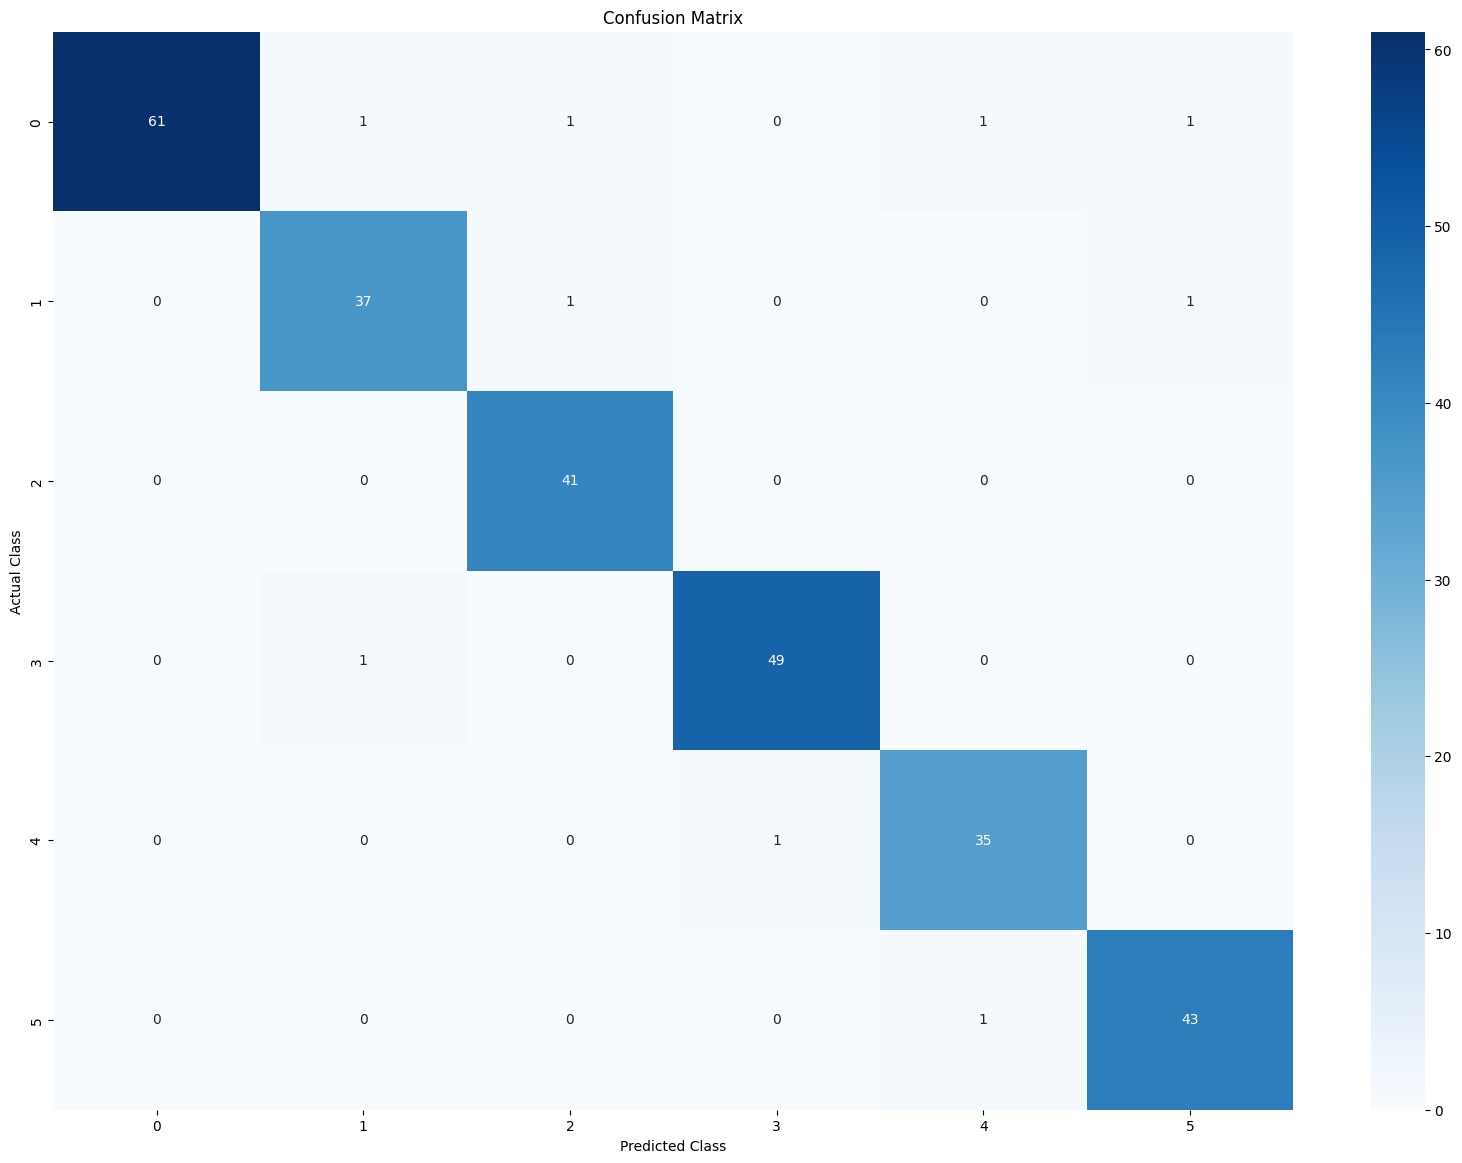

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using Seaborn's heatmap()
plt.figure(figsize=(20,14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()


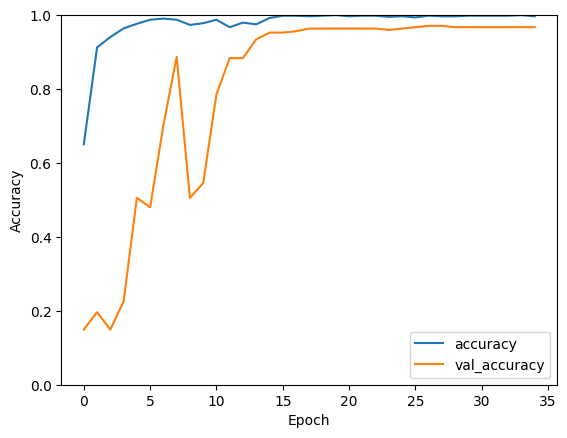

In [18]:
plt.plot(result.history['accuracy'], label='accuracy')
plt.plot(result.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [19]:
# Predict the labels for the test data
predictions = model.predict(X1_test)
predicted_classes_indices = np.argmax(predictions, axis=1)


9/9 [==============================] - 0s 38ms/step


In [20]:
true_classes_indices = np.argmax(Y1_test, axis=1)


In [21]:
class_names = ['Bruce Banner', 'Clint Barton', 'Natasha Romanoff', 'Steve Rogers', 'Thor', 'Tony Stark']
predicted_labels = [class_names[idx] for idx in predicted_classes_indices]
true_labels = [class_names[idx] for idx in true_classes_indices]


In [22]:
# Display the results
for i in range(len(predicted_labels)):
    print(f"Image {i+1}: Predicted - {predicted_labels[i]}, Actual - {true_labels[i]}")


Image 1: Predicted - Steve Rogers, Actual - Steve Rogers
Image 2: Predicted - Tony Stark, Actual - Tony Stark
Image 3: Predicted - Tony Stark, Actual - Clint Barton
Image 4: Predicted - Natasha Romanoff, Actual - Natasha Romanoff
Image 5: Predicted - Steve Rogers, Actual - Steve Rogers
Image 6: Predicted - Steve Rogers, Actual - Steve Rogers
Image 7: Predicted - Clint Barton, Actual - Clint Barton
Image 8: Predicted - Tony Stark, Actual - Tony Stark
Image 9: Predicted - Steve Rogers, Actual - Steve Rogers
Image 10: Predicted - Natasha Romanoff, Actual - Natasha Romanoff
Image 11: Predicted - Steve Rogers, Actual - Steve Rogers
Image 12: Predicted - Bruce Banner, Actual - Bruce Banner
Image 13: Predicted - Bruce Banner, Actual - Bruce Banner
Image 14: Predicted - Thor, Actual - Thor
Image 15: Predicted - Natasha Romanoff, Actual - Natasha Romanoff
Image 16: Predicted - Bruce Banner, Actual - Bruce Banner
Image 17: Predicted - Tony Stark, Actual - Tony Stark
Image 18: Predicted - Thor, A

In [23]:
# Assuming predicted_labels and true_labels are lists containing the predicted and actual labels respectively
correct_count = 0
incorrect_count = 0

# Display the results and count correct/incorrect predictions
for i in range(len(predicted_labels)):
    print(f"Image {i+1}: Predicted - {predicted_labels[i]}, Actual - {true_labels[i]}")
    if predicted_labels[i] == true_labels[i]:
        correct_count += 1
    else:
        incorrect_count += 1

# Print out the totals
print(f"Total correct predictions: {correct_count}")
print(f"Total incorrect predictions: {incorrect_count}")


Image 1: Predicted - Steve Rogers, Actual - Steve Rogers
Image 2: Predicted - Tony Stark, Actual - Tony Stark
Image 3: Predicted - Tony Stark, Actual - Clint Barton
Image 4: Predicted - Natasha Romanoff, Actual - Natasha Romanoff
Image 5: Predicted - Steve Rogers, Actual - Steve Rogers
Image 6: Predicted - Steve Rogers, Actual - Steve Rogers
Image 7: Predicted - Clint Barton, Actual - Clint Barton
Image 8: Predicted - Tony Stark, Actual - Tony Stark
Image 9: Predicted - Steve Rogers, Actual - Steve Rogers
Image 10: Predicted - Natasha Romanoff, Actual - Natasha Romanoff
Image 11: Predicted - Steve Rogers, Actual - Steve Rogers
Image 12: Predicted - Bruce Banner, Actual - Bruce Banner
Image 13: Predicted - Bruce Banner, Actual - Bruce Banner
Image 14: Predicted - Thor, Actual - Thor
Image 15: Predicted - Natasha Romanoff, Actual - Natasha Romanoff
Image 16: Predicted - Bruce Banner, Actual - Bruce Banner
Image 17: Predicted - Tony Stark, Actual - Tony Stark
Image 18: Predicted - Thor, A

In [24]:
def load_and_preprocess_image(image_path):
    # Load the image file, resizing it to 224x224 pixels (as expected by the model)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))

    # Convert the image to a numpy array and expand dimensions to be (1, 224, 224, 3)
    img = np.expand_dims(img, axis=0)



    return img


In [25]:
def predict_image_class(image_path, model):
    # Load and preprocess the image
    img = load_and_preprocess_image(image_path)

    # Make predictions
    predictions = model.predict(img)

    # Optionally, retrieve the most likely result
    predicted_class = np.argmax(predictions, axis=1)

    return predicted_class


In [33]:
image_path = "/content/drive/MyDrive/GP_YOLOV5Model/cris10.jpg"
predicted_class = predict_image_class(image_path, model)

print("Predicted class index:", predicted_class)


1/1 [==============================] - 0s 49ms/step
Predicted class index: [5]


In [34]:
from keras.models import load_model

# Correct the file path
model_path = "/content/drive/MyDrive/GP_YOLOV5Model/MobileNet2.h5"

# Assuming 'model' is your trained model variable
model.save(model_path)
print(f"Model saved successfully at {model_path}")

# To load the model later
model = load_model(model_path)
print("Model loaded successfully.")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully at /content/drive/MyDrive/GP_YOLOV5Model/MobileNet2.h5
Model loaded successfully.


In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,317,568 (20.28 MB)

 Trainable params: 5,291,630 (20.19 MB)

 Non-trainable params: 25,936 (101.31 KB)

 Optimizer params: 2 (12.00 B)

In [35]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.15.0
